In [1]:
import numpy as np
import pandas as pd

from pathlib import Path

from gtp.dataloading.tools import align_data, collect_chromosome

DNA_PROCESSED_DIR = Path("/local/scratch/carlyn.1/dna/processed/genome")
PHENO_PROCESSED_DIR = Path("/local/scratch/carlyn.1/dna/colors/processed/")

chromosome = 18

dna_camids, dna_data = collect_chromosome(DNA_PROCESSED_DIR, "erato", chromosome)

pheno_data = pd.read_csv(PHENO_PROCESSED_DIR / "erato_forewings_color_3" / "data.csv")

dna_data, dna_camids, pheno_data = align_data(dna_data, dna_camids, pheno_data)


Running Linear regression on SNPS:   0%|          | 0/1646818 [00:00<?, ?it/s]

Running Linear regression on SNPS: 100%|██████████| 1646818/1646818 [19:00<00:00, 1443.86it/s]


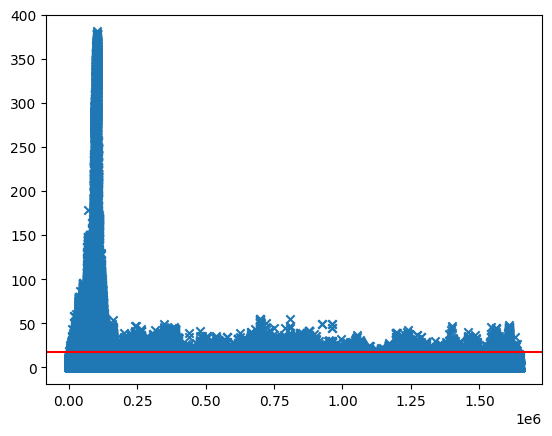

In [3]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from tqdm import tqdm

# 1, 0, 0 = 0 | 0, 1, 0 = 1 | 0, 0, 1 = 2
#snp_categories = (dna_data.astype(np.uint8) * np.array([0, 1, 2])).sum(2)

pvals = []
for snp in tqdm(range(dna_data.shape[1]), desc="Running Linear regression on SNPS"):
    # 1, 0, 0 = 0 | 0, 1, 0 = 1 | 0, 0, 1 = 2
    snp_categories = (dna_data[:, snp].astype(np.uint8) * np.array([0, 1, 2])).sum(1)
    if len(np.unique(snp_categories, return_counts=True)[0]) > 1:
        result = stats.linregress(snp_categories, pheno_data.PC1)
        pval = result.pvalue
        #data = np.concatenate((snp_categories[:, snp:snp+1], pheno_data.PC1.to_numpy()[:, np.newaxis], np.zeros_like(pheno_data.PC1.to_numpy()[:, np.newaxis])), axis=1)
        #df = pd.DataFrame(data, columns=["SNP", "PC1", "psuedo_group"])
        #md = smf.mixedlm("SNP ~ PC1", df, groups=df["psuedo_group"])
        #mdf = md.fit(method=["lbfgs"])
        #pval = mdf.pvalues.PC1
    else:
        pval = 1.0
    pvals.append(pval)
    
plt.figure()
y = -np.log(np.array(pvals))
plt.scatter(np.arange(0, len(y)), y, marker='x')
bonferroni_correction_pval = 5e-8
plt.axhline(y=-np.log(bonferroni_correction_pval), color='r', linestyle='-')
plt.show()